# Analysis of Tweets during Game 6 of the 2017 World Series

I decided to collects and analyze tweets that were sent during Game 6 of the 2017 World Series.  This game occurred on Oct 31, 2017 in Los Angeles, and pitted the L.A. Dodgers and the Houston Astros.  Going into the game, Houston led the best-of-7 series 3 games to 2.  

The tweets were collected using the twitter streaming API, using the tweepy package, and saved to text files. A script for collecting the tweets can be found in this directory, named twitterStreamToFile.py.   Only tweets containing the  the hashtag "#WorldSeries" were collected.  This surely doesn't contain all World Series-related tweets, but I considered it to be an adequate sample for a simple study.  About 150,000 tweets were collected during the approximate time period 7:25pm (Oct 31) to 12:45am (Nov 1), using the U.S. Eastern time zone.  There are small time gaps in the data, due to connection issues.

## Pre-processing of data

In [25]:
%matplotlib inline 
import json
import pandas as pd
import numpy as np
from collections import Counter
import re
from pytz import timezone
import pylab
#from geopy.distance import vincenty
import random
import pickle


import matplotlib.pylab as plt
import matplotlib.dates as dates
from mpl_toolkits.basemap import Basemap

from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
import nltk

from nltk.classify.scikitlearn import SklearnClassifier
#from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.figsize'] = (8,5.3)


Some tweets (unfortunately, only a couple percent) contain geographical information.  Most tweets containing geographical information don't contain exact longitude/latitude, but rather only contain a "bounding box" indicating that the tweet is associated with somewhere inside a square geographical region. For simplicity, we will approximate the tweet location by the center of the bounding box, unless the bounding box is too large (1 degree x 1 degree, roughly 70 miles x 70 miles), in which case we'll simply ignore the geographical information.

In [26]:
def addBoundBox(tweet,lonBoxCenters, latBoxCenters):
    
    myCoords = tweet['place']['bounding_box']['coordinates']
  #  print(myCoords)
#    print("x = ",myCoords[0][0])
#    print("x = ",myCoords[0][1])
    x1, x2 = myCoords[0][0][0], myCoords[0][2][0]
    y1, y2 = myCoords[0][0][1], myCoords[0][1][1]
    
    if(abs(x2-x1)>1 or abs(y2-y1)>1):  #about 70 miles x 70 miles
        #print("WARNING: bounding box not precise")
        #print("x = ",x1, "  to ",x2)
        #print("y = ",y1, "  to ",y2)
        #print(tweet['place']['name'])
        #pass
        lonBoxCenters.append( -9999 )
        latBoxCenters.append( -9999 )

    else:
        lonBoxCenters.append( 0.5*(x1+x2))
        latBoxCenters.append( 0.5*(y1+y2))


We will also write a function to process the text of the tweet.  We will want to analyze the individual words in the tweet, so we have a parser that splits up the tweet into words.  We also do some special text processing, such as replacing unicode characters for ellipsis points (...) and apostrophes, to make it easier to compare tweets.  We also use some regex (regular expressions) to handle the removal of punctuation marks and url's. Tweets sometimes have poor punctuation and spacing, so it is kind of tricky to parse them correctly.  I have tested this code, and it seems to work quite well. 

In [27]:
def cleanupWord(word):

    regp = re.compile(r'\u2026')
    word = regp.sub('...',word)   #replace special unicode ellipsis points.
    regp = re.compile(r'\u2019')
    word = regp.sub("'",word)   #replace special unicode apostrophes.

    
    regp = re.compile(r'^[?\.!:]+|[?\.!:\',]+$',re.IGNORECASE)
    #return [word]
    word = regp.sub('',word)
    regp = re.compile(r'^http',re.IGNORECASE)
    if regp.match(word):
        return []
    
    listOfWords = [word]
 
    regNumber = re.compile(r'^[0-9]+\.[0-9]+')
    if not regNumber.match(word):  #if it's not a decimal number, split into multiple words
        pp = re.compile(r'[\.]+')
        listOfWords = pp.split(word)
  #      print("word list = ",listOfWords)

    return listOfWords

def processTweet(origTweet):    
    words =  origTweet.split()
    words_clean = []
    for word in words:
        word_clean = cleanupWord(word)
        if word_clean!="":
            words_clean += word_clean
#    print(words_clean)
    return words_clean


No we actually cycle through the text files (containing the tweets in JSON format), and read in the tweet information. The tweets were broken into multiple files, in chronological order.

In [146]:
doTimeSeries=False
doMaps=False
doTrainSentiment=True
doSentiment=False


nullVal=-9999
times_created = []
langs = []
all_words = []
lonPts = []
latPts = []
lonBoxCenters =[]
latBoxCenters =[]
all_tweets = []
all_fulltext = []
numBoundBox=0

fileIndex1=3
fileIndex2=8



lineNum=0

for fIndex in range(fileIndex1,fileIndex2+1):
    fileName = 'worldSeries%d.json'%fIndex
    #print("File ",fileName)
    

    f = open(fileName,'r')

    
    for line in f:
      #  print(line,"\n\n")
        try:
            tweet = json.loads(line)
            bodytext = tweet['text']
        except:
            continue
        bodytext = tweet['text']
        all_fulltext.append(bodytext)
        language = tweet['lang']
        langs.append(language)
        times_created.append( tweet['created_at'] )
        if tweet['coordinates']:
            #print(tweet['coordinates']['coordinates'])
            #print(tweet['lang'])
            lonPts.append( tweet['coordinates']['coordinates'][0] )
            latPts.append( tweet['coordinates']['coordinates'][1] )
        
        if tweet['place']:
            numBoundBox+=1
            addBoundBox(tweet,lonBoxCenters, latBoxCenters)
        else:
            lonBoxCenters.append(nullVal)
            latBoxCenters.append(nullVal)

        parsedText = processTweet(bodytext.lower()) #only save lower-case versions
        all_tweets.append( parsedText )
#        print("lineNum = ",lineNum, " ",len(all_tweets), " ; ",len(lonBoxCenters))

        for word in parsedText:
            all_words.append( word.lower() )  
    
        lineNum+=1
        #if (lineNum%500)==0:
        #    print("line number = ",lineNum)
    


## Language and word frequencies

Now that we have the data loaded, let's due a basic linguistic analysis of the data. Each tweet contains information on the language used.  This is not necessarily the language of the individual tweet, but might just be the primary language of the person who sent the tweet.  Let's see which languages were the most common for these "#WorldSeries" tweets.

In [30]:
def plotFreqHist( myCounter, numToPlot):

#    fig = plt.figure(figsize=(36,5.3))
    fig, ax = plt.subplots(figsize=(8,10))
    
    
    #unzip the counter
    labels, counts = zip(*myCounter.most_common(numToPlot))
    print(labels)
    print(counts)

    yIndices = np.arange(len(labels))
    ax.barh(yIndices, counts, align='center')
    ax.set_yticks(yIndices)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
#    plt.bar(xIndices, counts)
#    plt.xticks(xIndices, labels)
    ax.set_xlabel("# of occurences of word")
    plt.show()

[('en', 136962), ('und', 9371), ('es', 4567), ('ja', 1013), ('da', 567), ('pt', 506), ('fr', 343), ('no', 225), ('nl', 220), ('in', 131), ('tl', 121), ('it', 98), ('de', 98), ('ht', 50), ('hi', 41), ('et', 38), ('tr', 31), ('sv', 27), ('ro', 24), ('cy', 19)]
('en', 'und', 'es', 'ja', 'da')
(136962, 9371, 4567, 1013, 567)


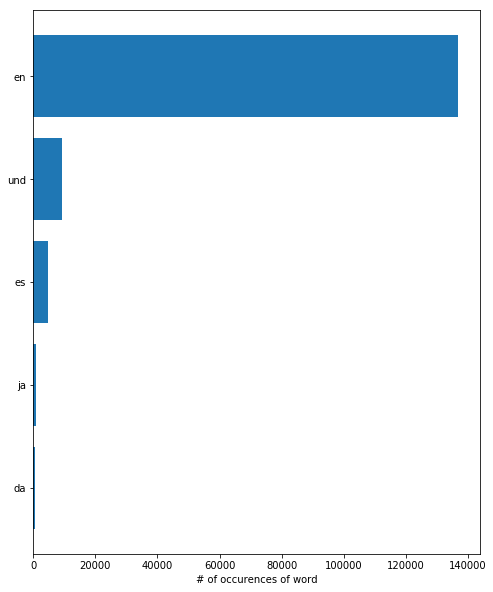

In [31]:
#################################
#####language frequency
#################################
langcount = Counter()
for lang in langs:
    langcount[lang]+=1
print(langcount.most_common(20))

#print(langcount.items())

plotFreqHist( langcount , 5)

We see that "en" (English) is the dominant language, which is unsurprising.  The "und" category refers to an undefined language (the user probably didn't specify a language).  The second-most popular language is Spanish ("es"), which again is unsurprising.

Next, let's look at which words were most commonly included in the tweets.  We will ignore common, uninteresting English words like it, I, am, do, etc (sometimes called "stop words").  NLTK contains a corpus of common stop words, which we will use.  We will also ignore a few other words: "RT" (standard abbreviation used when re-tweeting), "it's," and "#WorldSeries" (since that's the term we filtered on, it will obviously be common in our tweets).

('game', '@dodgers', '7', '#thisteam', 'win', '6', '@mlb', '#earnhistory', 'dodgers', 'go', '#dodgers', 'time', 'astros', 'one', '#astros', '@astros', 'seven', '#jocpop', '3-1', "let's", '#hr4hr', 'goals', 'relationship', 'got', 'like')
(53269, 44702, 25523, 24575, 13551, 12350, 11500, 10904, 10178, 10011, 9803, 8803, 8053, 7554, 7306, 7079, 6480, 6238, 6132, 5919, 5652, 5527, 5457, 5378, 4867)


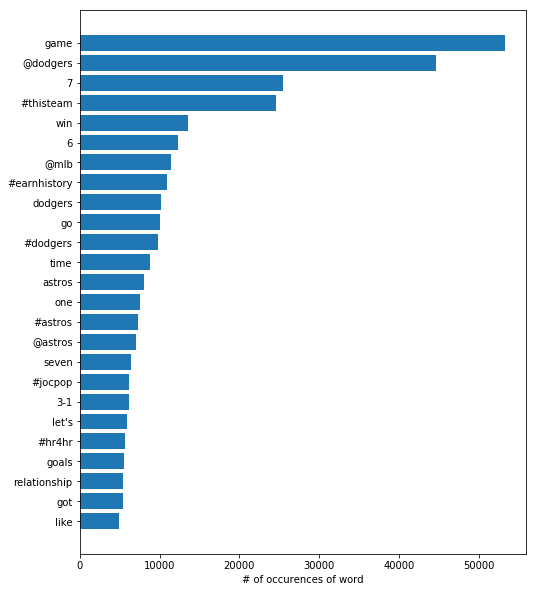

In [32]:
#################################
#####word frequency
#################################

#list of common words that we will ignore
stopWordList = stopwords.words('english') + ['rt', "it's", '#worldseries']

words_nostop = []
for word in all_words:
    if word not in stopWordList:
        words_nostop.append(word)

wordcount = Counter()
for word in words_nostop:
    wordcount[word]+=1
#print(wordcount.most_common(1000))

plotFreqHist( wordcount, 25 )


Most of these words are self-explanatory and make sense.  A few explanations:

6:  This was Game 6.

7/seven:  Lots of tweets were discussing Game 7, especially after L.A. won, guaranteeing a Game 7.

3-1: The final score of the game.

\#ThisTeam:  This was a popular hashtag adopted by Dodgers fans.

\#EarnHistory: This was a popular hashtag adopted by Astros fans.

\#hr4hr:  "Home Runs for Hurricane Recovery," a T-Mobile disaster-relief campaign.

Some non-obvious words:

"relationship" and "goals":  Why would these words be so common in World Series tweets? It wasn't at all obvious to me why these words would be common.  Some investigation revealed that there was a heavily re-tweeted tweet showing Ashton Kutcher and Mila Kunis attending the game, which contained the phrase "relationship goals."  So that's the explanation.  One viral tweet was enough to make those words enter the top-25 list.

\#jocpop: The meaning of this hashtag will become clear later, once we look at time series data.

## Time Series Analysis

Each tweet contains a timestamp, so we can look at how the tweeting varied as a function of time.  We'll use Pandas to plot the time series.  The tweets use the GMT time zone, so we will convert them to U.S. Eastern time before plotting them. 

In [33]:
def plotTimeSeries( timeLists, legendNames ):
    print("Starting plotTimeSeries()")
    if len(timeLists)!=len(legendNames):
        print("Input lists for plotTimeSeries are wrong...")
        return
    
    print("number of lists = ",len(timeLists))

    fig, ax = plt.subplots()

    
    for sIndex in range(len(timeLists)):
        
        legendName = legendNames[sIndex]
        timeList = timeLists[sIndex]
        if len(timeList)==0:
            print("No data to plot. Skipping...")
            return
        
        #print(timeList)
    
        time_idx = pd.DatetimeIndex(timeList)
        
        ones = [1]*len(timeList)
        
        #print(ones)
        
        time_numTweets = pd.Series(ones, index=time_idx)
        #print(time_numTweets.head(10))
        
        #time_numTweets_1sec = time_numTweets.resample('1Min',how='sum').fillna(0)
        
        
        time_numTweets_1sec = time_numTweets.resample('1Min').sum().fillna(0)
        #print(time_numTweets_1sec.head(10))
        
        time_numTweets_1sec_local = time_numTweets_1sec.tz_localize('GMT')
        time_numTweets_1sec_local = time_numTweets_1sec_local.tz_convert('US/Eastern')
        
        
        #print(time_numTweets_1sec_local.head())
        ax.plot(time_numTweets_1sec_local, label=legendName)
        
        #time_numTweets_1sec_local.plot(label=legendName)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M',tz=timezone('US/Eastern')))
    ax.xaxis.set_major_locator(dates.MinuteLocator([0,30,60]))
    ax.xaxis.set_minor_locator(dates.MinuteLocator(range(0,60,10)))
        
    pylab.legend(loc='upper left')
    plt.xlabel("Time (US/Eastern)")
    plt.ylabel("# of tweets")
    
    plt.show()


First, let's plot the times of all the tweets in our data set:

Starting plotTimeSeries()
number of lists =  1


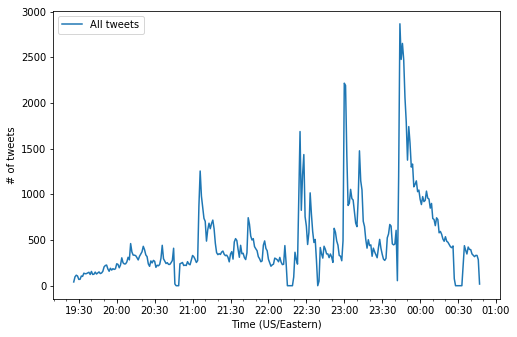

In [34]:
plotTimeSeries([times_created], ["All tweets"])


Very interesting!  We see some clear peaks in Twitter activity.  We can compare these peaks to major events in the game:
    
8:20pm:  Start of game.
9:05pm:  George Springer hits a solo home run.  Astros 1-0.
9:36-9:47pm:  Top of 5th inning. Dodgers have a major scoring opportunity. They get the bases loaded, but Bregman grounds out to end the inning.
10:24pm:  Tayloe ties the game 1-1 with a double.
10:27pm:  Dodgers score another run (sac fly by Seager). Dodgers now lead 2-1.
10:33pm:  End of 6th inning (end of Dodgers' scoring).
10:59pm:  Joc Pederson hits a solo home run for the Dodgers.  Dodgers 3-1.
11:43pm:  End of game.

We see clear jumps in the number of Tweets after each score.  Then we see a huge number of tweets when the game ends, which dies off rather slowly.

Let's take a closer look at these tweets.  One interesting question is whether Astros fans or Dodgers fans tweeted more during certain times.  We can use the #EarnHistory hashtag as a good proxy for Astros fans, and the #ThisTeam hashtag as a good proxy for Dodgers fans. Let's plot only tweets containing these two hashtags:

Doing time series studies
Starting plotTimeSeries()
number of lists =  2


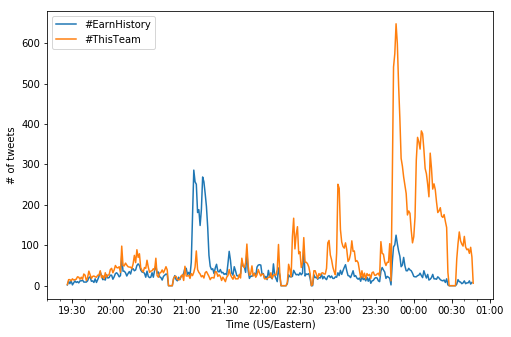

In [38]:
def getTweetTimes(timeSubList,searchText,fullTweetList,fullTimeList):
    
    for iTweet in range(len(fullTweetList)):
        if searchText in fullTweetList[iTweet]:
            timeSubList.append( fullTimeList[iTweet] )


print("Doing time series studies")
    
times_earnhistory= []
times_thisteam = []
times_jocpop = []
if len(times_created)==len(all_tweets):
    getTweetTimes(times_earnhistory,'#earnhistory',all_tweets,times_created)
    getTweetTimes(times_thisteam,'#thisteam',all_tweets,times_created)
    getTweetTimes(times_jocpop,'#jocpop',all_tweets,times_created)        
else:
    print("Eek! lengths don't agree!!")
    
plotTimeSeries([times_earnhistory, times_thisteam], ["#EarnHistory","#ThisTeam"])

The results seem to make sense Astros fans (#EarnHistory) tweeted a lot when they scored, and Dodgers fans (#ThisTeam) tweeted a lot when they scored.  These hashtags are the kind of "Go team, go!" messages that you would expect to be tweeted after a positive occurrence in the game.  We also see at the end of the game there is a minor boost in #EarnHistory tweets (makes sense; Astros fans still have Game 7 to look forward to, even if they lost Game 6), but a huge explosion in #ThisTeam tweets, which makes sense since the Dodgers won.

We saw earlier that the #jocpop hashtag was one of the most frequent words in the tweets.  Let's find out when the tweets containing #jocpop happened:

Starting plotTimeSeries()
number of lists =  2


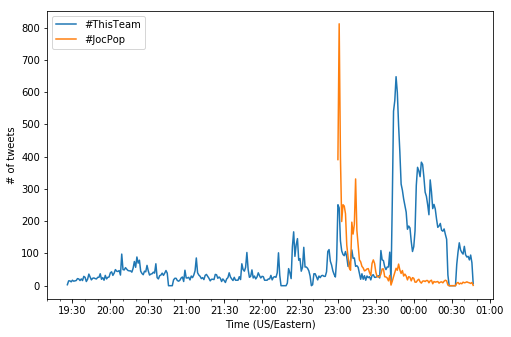

In [39]:
plotTimeSeries([times_thisteam, times_jocpop], ["#ThisTeam","#JocPop"])


Aha! The #JocPop hashtag didn't occur at all until about 11:00pm, when there was a sudden explosion of #JocPop tweets.  This coincided with an increase in #ThisTeam tweets.  We can see that this happened right after the Joc Pederson home run.  So that's what #JocPop means:  Joc Pederson home run.

## Maps of Tweets (Geographical Analysis)

As mentioned earlier, some tweets have geographical informatino associated with them, so we can see where the Twitter users are.  Unfortunately, most of the tweets don't contain this geographical information so we can't plot them, but enough tweets do that we can still make some interesting plots.

Let's first make a world map of the locations of all the #WorldSeries tweets.  For this exercise, we'll use Python's BaseMap package.

In [147]:
import warnings
warnings.filterwarnings('ignore')  #suppress some warning messages

def drawMap(lonPtList, latPtList, labels, viewMode):
    print("drawing map")
    markSize = 0.3 #1.3 for big markers
    
    fig = plt.figure(figsize=(6,2),dpi=250)
    
    myColors=['red','blue']
    
    plt.title('Distribution of tweets')
    #world map
    xMin, xMax = -180.0, 180.0
    yMin, yMax = -60.0, 70.0
    if viewMode=="world":
        pass
    elif viewMode=="NorthAm":
        xMin, xMax = -160.0, -50.0
        yMin, yMax = 10.0, 60.0
    elif viewMode=="Texas":
        xMin, xMax = -109.0, -93.0
        yMin, yMax = 24.0, 38.0        
    elif viewMode=="Calif":
        xMin, xMax = -130.0, -114.0
        yMin, yMax = 31.0, 43.0
    elif viewMode=="custom":
        xMin, xMax = -112, -85.0
        yMin, yMax = 12.0, 38.0
    
    
  #  myMap = Basemap(llcrnrlon=-180.0,llcrnrlat=-60.0,urcrnrlon=180.0,urcrnrlat=70.0, 
   #North America map
#    myMap = Basemap(llcrnrlon=-160.0,llcrnrlat=10.0,urcrnrlon=-50.0,urcrnrlat=60.0, 
    myMap = Basemap(llcrnrlon=xMin,llcrnrlat=yMin,urcrnrlon=xMax,urcrnrlat=yMax, 
                    resolution='l',
                    projection='merc',
                    lat_0=38.0, 
                    lon_0=-97.0)

    myMap.drawmapboundary(fill_color='aqua')
    myMap.drawcountries()
    if viewMode!="world":
        myMap.drawstates()
    myMap.fillcontinents(color='gray',zorder=0)
    
    numValidPts=0
    
    for sIndex in range(len(latPtList)):
        latPts = latPtList[sIndex]
        lonPts = lonPtList[sIndex]
        xVal=[]
        yVal=[]        
        for ii in range(len(latPts)):
            lonVal, latVal = lonPts[ii], latPts[ii]
            if lonVal>-200 and latVal>-200:
            
                numValidPts+=1
                xx,yy=myMap(lonVal,latVal)
                xVal.append(xx)
                yVal.append(yy)
                #print(" xx = ",xx," yy = ",yy)
#                myMap.plot(xx, yy, color=myColors[sIndex], marker='o',markersize=markSize,label='huh')
    

        myMap.scatter(xVal, yVal, color=myColors[sIndex], marker='o',s=markSize,label=labels[sIndex])
    
    print("Plotting ",numValidPts," valid tweets on map")
    
    if len(latPtList)>1:
        pylab.legend(loc='upper left')

    
  #  myMap.bluemarble(scale=0.3)
    plt.show()


drawing map
Plotting  6612  valid tweets on map


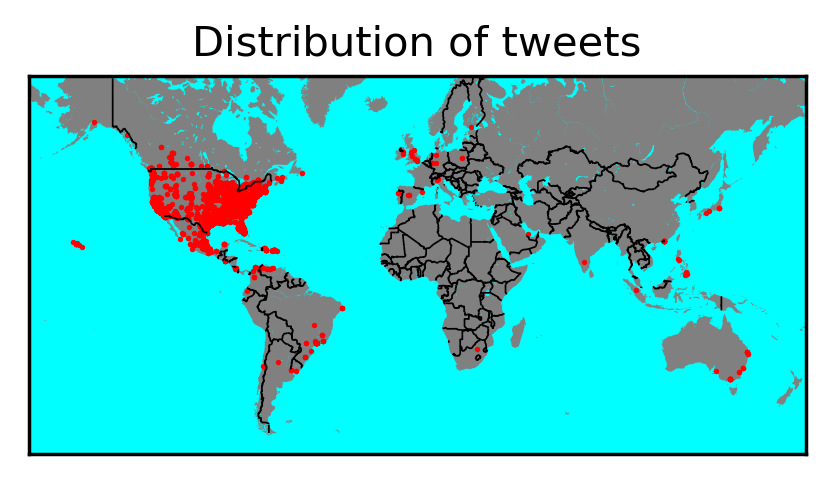

In [148]:
drawMap([lonBoxCenters], [latBoxCenters],["all tweets"],"world")

Nice!  We can see that the tweets are coming overwhelmingly from the U.S., but with a rather significant amount of tweets from Mexico, too. Outside of North America, there are tweets from every other continent (except for Antarctica), but the number of tweets is quite small. In particular, there's only one point in Africa.

Now let's zoom in on the U.S., and see where Astros and Dodgers fans are located, by plotting the locations of #EarnHistory and #ThisTeam tweets.

drawing map
Plotting  1926  valid tweets on map


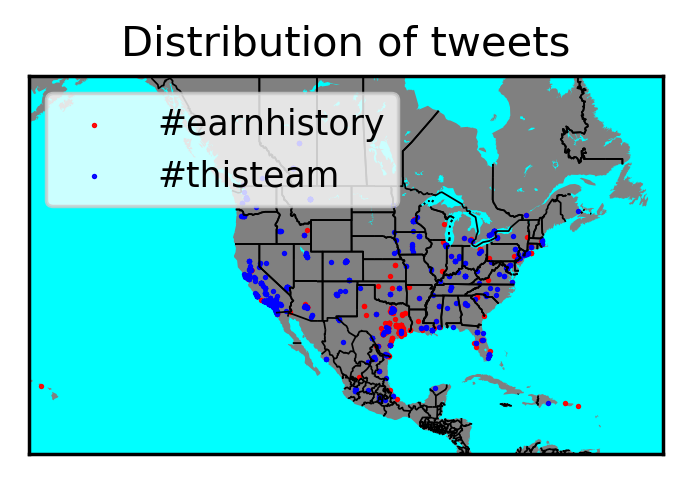

In [149]:
def getTweetLocs(longSubList,latSubList,searchText,fullTweetList,fullLongList,fullLatList):
    
    for iTweet in range(len(fullTweetList)):
        if searchText in fullTweetList[iTweet]:
            longSubList.append( fullLongList[iTweet] )
            latSubList.append( fullLatList[iTweet] )



lon_earnhistory= []
lat_earnhistory= []
lon_thisteam = []
lat_thisteam = []
    
if len(lonBoxCenters)==len(all_tweets):
    getTweetLocs(lon_earnhistory,lat_earnhistory, '#earnhistory',all_tweets,lonBoxCenters,latBoxCenters)
    getTweetLocs(lon_thisteam,lat_thisteam, '#thisteam',all_tweets,lonBoxCenters,latBoxCenters)
else:
    print("ERROR!!!")
#    print(len(all_tweets))
#    print(len(lonBoxCenters))
    
drawMap([lon_earnhistory, lon_thisteam],[lat_earnhistory, lat_thisteam],["#earnhistory","#thisteam"],"NorthAm")

We see a concentration of #EarnHistory tweets in southeastern Texas, and a concentration of #ThisTeam tweets in southern California, as expected.

## Training a Classifier for Sentiment Analysis

Lastly, we will look at a type of textual analysis known as "sentiment analysis."  The idea is that different pieces of text convey different emotions or sentiments.  In this project, I will just distinguish between "positive" sentiments and "negative" sentiments.  For example, "Yes! Go Astros!" is cleary a "positive" tweet, whereas "Ugh! This is a total disaster! :(" is clearly a negative tweet.  Designing algorithms that can determine whether a piece of text has a positive or negative sentiment is an important problem in machine learning.

I will start by training a machine learning algorithm to distinguish between positive and negative tweets.  First, we need some training data.  Luckily, such data already exists; there is an NLTK corpus 5000 positive and 5000 negative tweets.  We will read in this data:

In [76]:
random.seed(243134)

nltkPosTweets = twitter_samples.tokenized('positive_tweets.json')
nltkNegTweets = twitter_samples.tokenized('negative_tweets.json')

We want to make sure that the training data is well randomized in order to avoid possible bias, so let's shuffle the order of the data.

In [77]:
random.shuffle(nltkPosTweets)
random.shuffle(nltkNegTweets)

Now, let's label the positive tweets as "pos" and the negative tweets as "neg" and then mix these tweets together, so we have a randomized mixture of positive and negative tweets.

In [79]:
nltkAllTweets = []
    
for tweet in nltkPosTweets:
    nltkAllTweets.append( (tweet, "pos") )
for tweet in nltkNegTweets:
    nltkAllTweets.append( (tweet, "neg") )
    
random.shuffle(nltkAllTweets)

The features that we'll use for the machine learning are the 1000 most common words.  For each of these 1000 words, we'll set a value of 1 if the word is present in a given tweet, and a value of 0 if the word is not present.

For example, let's say the most common words are ["the","a","I","is","you","are","am",....].  Then, for the tweet "I am looking forward to the game" the feature set would have the values [1,0,1,0,0,0,1,.....].

First we'll need to find out which are the 1000 most common words in the Twitter corpus. We can use the nltk.FreqDist function.

In [80]:
numFeatures=1000
allNltkWords = []
for tweet in nltkAllTweets:
    for word in tweet[0]:
        allNltkWords.append(word.lower())
    
allNltkWords = nltk.FreqDist(allNltkWords)
sentFeatures = list(key for (key,value) in allNltkWords.most_common(numFeatures))

Now we compute the features for each tweet.

In [81]:
def getSentFeatures(text, featureList):
    wordSet = set(text)
    myFeatures = {}
    for ff in featureList:
        myFeatures[ff] = (ff in wordSet)
    #print(myFeatures)

    return myFeatures

corpusFeatureData = []
for (tweet, sentiment) in nltkAllTweets:
    corpusFeatureData.append ( (getSentFeatures(tweet, sentFeatures), sentiment) )

Now we split the corpus data into a training set and a test set.  We'll put 60% of the tweets in the training set, and 40% in the test set.  We've already shuffled the tweets, so we will have a roughly equal mixture of positive and negative tweets in each set.

In [82]:
print("Training + test size = ",len(corpusFeatureData))
trainingData = corpusFeatureData[0:6000]
testData = corpusFeatureData[6000:]

Training + test size =  10000


Now we can train a classifier.  We'll use a Naive Bayes classifier.

In [85]:
naiveClassifier = nltk.NaiveBayesClassifier.train(trainingData)
    
print("Accuracy of Naive Bayes Classifier on training: ",nltk.classify.accuracy(naiveClassifier,trainingData))
print("Accuracy of Naive Bayes Classifier on test: ",nltk.classify.accuracy(naiveClassifier,testData))

Accuracy of Naive Bayes Classifier on training:  0.9918333333333333
Accuracy of Naive Bayes Classifier on test:  0.98725


The extremely accurate performance on the test data is rather surprising.  Let's see which words in the tweets were most informative in distinguishing between positive and negative tweets.

In [89]:
naiveClassifier.show_most_informative_features(10)

Most Informative Features
                      :( = True              neg : pos    =   1771.3 : 1.0
                      :) = True              pos : neg    =    856.5 : 1.0
                     sad = True              neg : pos    =     29.0 : 1.0
                 arrived = True              pos : neg    =     22.4 : 1.0
                    miss = True              neg : pos    =     19.1 : 1.0
                   loves = True              pos : neg    =     19.0 : 1.0
                   great = True              pos : neg    =     15.6 : 1.0
               followers = True              pos : neg    =     15.0 : 1.0
                  missed = True              neg : pos    =     14.3 : 1.0
               community = True              pos : neg    =     13.7 : 1.0


We see that the presence of :) and :( emojis is an extremely good indicator of positive/negative tweets.  Unfortunately, most of our World Series tweets don't contain these emojis, so we shouldn't expect such high accuracy for the World Series tweets.  

As a sanity check, let's see how our classifier performs on the two example tweets we mentioned earlier: "Yes! Go Astros!" and "Ugh! This is a total disaster! :(".



In [136]:
def getSentPrediction(tokens,featureList,myClassifier): 
#    print("tokens = ",tokens)
    featureVals = getSentFeatures(tokens, featureList)
    prediction = myClassifier.classify(featureVals)
    #print("prediction = ",prediction," prob = ",myClassifier.prob_classify(featureVals).prob('pos'))
    #prob = myClassifier.prob_classify(featureVals).prob('pos')
    return prediction

tknzer = TweetTokenizer()

example1 = "Yes! Go Astros!"
example2 = "Ugh! This is a total disaster! :("
myPredict1 = getSentPrediction(tknzer.tokenize(example1),sentFeatures,naiveClassifier)
myPredict2 = getSentPrediction(tknzer.tokenize(example2),sentFeatures,naiveClassifier)


print(example1," ==> sentiment prediction:",myPredict1)
print(example2," ==> sentiment prediction:",myPredict2)

Yes! Go Astros!  ==> sentiment prediction: pos
Ugh! This is a total disaster! :(  ==> sentiment prediction: neg


Great!  At least for those simple sentences, the classifier correctly determined their sentiments.  We can now save our features and trained classifier for later use.

In [91]:
f_features = open("saved1/featuresnb1000.pickle","wb")
pickle.dump(sentFeatures, f_features)
f_features.close()
   
f_nbClassifier = open("saved1/nb1000.pickle","wb")
pickle.dump(naiveClassifier, f_nbClassifier)
f_nbClassifier.close()
 

## Sentiment Analysis of World Series Tweets

We'll now apply our trained sentiment classifier to the World Series tweets.  

In [99]:


f_features = open("saved/featuresnb1000.pickle","rb")
sentFeatures = pickle.load(f_features)
f_features.close()

f_logistClassifier = open("saved/nb1000.pickle","rb")
myClassifier = pickle.load(f_logistClassifier)
f_logistClassifier.close()

tweetTimesPos=[]
tweetTimesNeg=[]

words_pos_tweets = []
words_neg_tweets = []

my_sentiment = []


tknzer = TweetTokenizer()

for iTweet in range(len(all_tweets)):
    tweet = all_fulltext[iTweet]

    myPredict = getSentPrediction(tknzer.tokenize(tweet),sentFeatures,myClassifier)

    if(myPredict=="neg"):
        tweetTimesNeg.append( times_created[iTweet] )
        
        for word in all_tweets[iTweet]:
            if word not in stopWordList:
                words_neg_tweets.append(word)

    elif(myPredict=="pos"):
        tweetTimesPos.append( times_created[iTweet] )#
        
        for word in all_tweets[iTweet]:
            if word not in stopWordList:
                words_pos_tweets.append(word)
        
        
    my_sentiment.append(myPredict)
    
print("# positive tweets = ",len(tweetTimesPos), "# negative tweets = ",len(tweetTimesNeg))

    

# positive tweets =  132404 # negative tweets =  22190


The first observation is that there are many more positive tweets than negative tweets (about a factor of 6 times more).  It appears that fans remained optimistic, or at least did not vent their anger on Twitter.

Let's plot the time distributition separately for the positive tweets and negative tweets.

Starting plotTimeSeries()
number of lists =  2


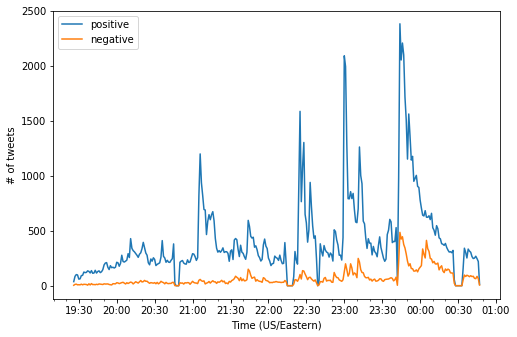

In [100]:
plotTimeSeries([tweetTimesPos, tweetTimesNeg], ["positive","negative"])
        


Not particularly enlightening. People sent positive tweets at the expected times (during scores end at the end of the game).  There was no time period when the negative tweets dominated over the positive tweets, although there seems to have been a fairly significant number of negative tweets at the end of the game.

Let's see which words occured frequently in positive tweets:

('game', '@dodgers', '#thisteam', '7', '6', '@mlb', '#earnhistory', 'dodgers', 'go', '#dodgers', 'astros', 'win', 'one', '@astros', '#astros', 'seven', '3-1', "let's", 'goals', '#jocpop')
(42582, 42136, 19489, 16247, 11939, 10201, 9972, 9186, 8915, 8754, 7419, 7006, 6875, 6447, 6416, 6385, 5959, 5570, 5509, 5483)


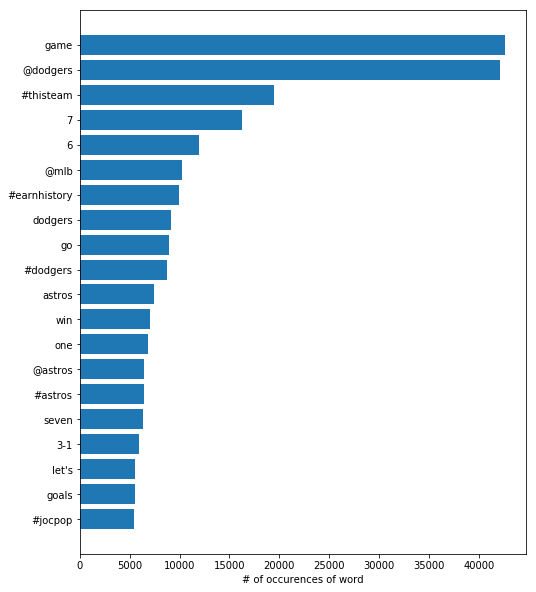

In [139]:
wordcount_pos = Counter()
for word in words_pos_tweets:
    wordcount_pos[word]+=1

#print(wordcount_pos.most_common(200))

plotFreqHist( wordcount_pos, 20 )



And which words were frequent in negative tweets:

('game', '7', 'win', '#thisteam', '@yasielpuig', 'time', 'baby', '👅', '@dodgers', 'home', 'would', 'said', '@mlb', 'last', 'series', 'go', 'like', '#dodgers', 'dodgers', '#earnhistory')
(10687, 9276, 6545, 5086, 4197, 3753, 3123, 2759, 2566, 1711, 1542, 1406, 1299, 1227, 1098, 1096, 1068, 1049, 992, 932)


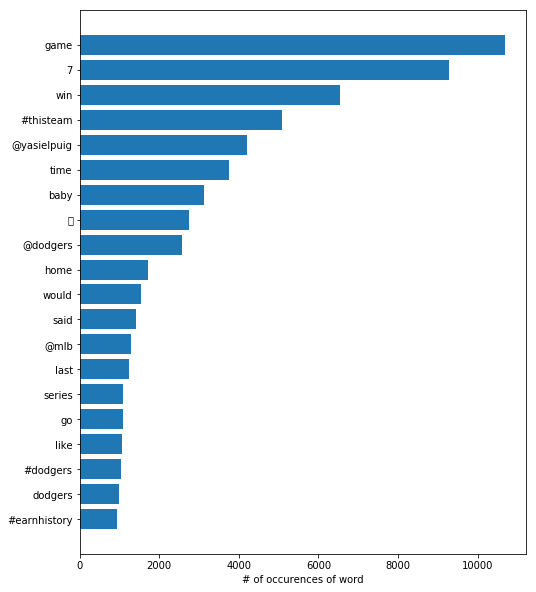

In [144]:
wordcount_neg = Counter()
for word in words_neg_tweets:
    wordcount_neg[word]+=1
#print(wordcount_neg.most_common(200))

plotFreqHist( wordcount_neg, 20 )

The differences between the positive and negative tweets aren't as large as I expected. 

The fact that @dodgers is the second-most common word in positive tweets sounds right, but the dodgers are also mentioned fairly frequently in the negative tweets (as a percentage of the total number of negative tweets, which is admittedly rather small).  If you look deeper in the list of frequent words, there are other things that make sense: words like "traumatized" "😫" are fairly common in the negative tweets.  The positive tweets contain lots of occurences of "🎶," "love," "#letsgododgers," and "#celebrationmusic."

There are some strange results, though.  @yasielpuig and the 👅 emoji (which is the 7th-most frequent "word" in negative tweets, but not properly displayed in the plot) are surprisingly frequent.  This seems to stem from one frequently-retweeted tweet, which was actually positive, but misclassified as negative. This illustrates some challenges with the analysis.  First, Twitter data contains many retweets, and sometimes one massively popular tweet can bias your result.  Second, classifying tweets is quite challenging, especially when we only have 10,000 labeled tweets from the NLTK corpus to work with.  One possibility is to change the classification thresholds, such that only clearly negative/positive tweets are classified as negative/positive, and uncertain tweets are classified as neutral.

Anyway, the sentiment analysis was still interesting.  The main conclusive result seems to be that positive tweets were much more common than negative tweets.